<a href="https://colab.research.google.com/github/jmq19950824/Machine-Learning-with-Python/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torchvision.models import densenet121
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


%matplotlib inline

GPU Environment

In [2]:
is_cuda=torch.cuda.is_available()
is_cuda

True

Original Data

In [0]:
data_transform=transforms.Compose([transforms.Resize((299,299)),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

In [0]:
train_dataset=ImageFolder('/content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/minitrain',transform=data_transform)
valid_dataset=ImageFolder('/content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/minivalid',transform=data_transform)

train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=False,num_workers=8)
valid_dataloader=DataLoader(valid_dataset,batch_size=32,shuffle=False,num_workers=8)

In [5]:
print(train_dataset)
print(valid_dataset)

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/minitrain
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/drive/My Drive/Book Codes/PyTorch深度学习/dogsandcats/minivalid
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Create DenseNet Model

In [6]:
model_densenet=densenet121(pretrained=True).features

if is_cuda:
  model_densenet=model_densenet.cuda()

for p in model_densenet.parameters():
  p.requires_grad=False

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


Extracting Convolutional Features

In [0]:
train_features=[]
train_labels=[]

for data,label in train_dataloader:
  output=model_densenet(Variable(data.cuda()))
  output=output.view(output.size(0),-1)

  train_labels.extend(label)
  train_features.extend(output.cpu().data)

In [0]:
valid_features=[]
valid_labels=[]

for data,label in valid_dataloader:
  output=model_densenet(Variable(data.cuda()))
  output=output.view(output.size(0),-1)

  valid_labels.extend(label)
  valid_features.extend(output.cpu().data)

Customize the Dataset

In [0]:
class FeaturesDataset(Dataset):
  def __init__(self,featurelist,labellist):
    self.featurelist=featurelist
    self.labellist=labellist

  def __getitem__(self,index):
    return(self.featurelist[index],self.labellist[index])

  def __len__(self):
    return len(self.labellist)

Creating Train and Validation Feature Dataset

---

(DataLoader)

In [0]:
train_feature_dataset=FeaturesDataset(train_features,train_labels)
valid_feature_dataset=FeaturesDataset(valid_features,valid_labels)

train_feature_loader=DataLoader(train_feature_dataset,batch_size=64,shuffle=True,drop_last=True)
valid_feature_loader=DataLoader(valid_feature_dataset,batch_size=64)

In [0]:
class FullyConnectedModel(nn.Module):
  def __init__(self,input_size,output_size,training=True):
    super().__init__()
    self.fc=nn.Linear(input_size,output_size)

  def forward(self,input):
    output=F.dropout(input,training=self.training,p=0.5)
    output=self.fc(output)
    return output

In [51]:
print(train_features[0].size(0))

fc_in_size=train_features[0].size(0)
classes=2

fc=FullyConnectedModel(fc_in_size,classes)

if is_cuda:
  fc=fc.cuda()

82944


Optimizer

In [0]:
optimizer=optim.Adam(fc.parameters(),lr=0.01)

Fit the Model

In [0]:
def fit(model,data_loader,phase='training',volatile=False):

  running_loss=0.0
  running_correct=0
  if phase=='training':
    model.train()
  if phase=='validation':
    model.eval()
    volatile=True

  for batch_idx,(data,target) in enumerate(data_loader):
    if is_cuda:
      data,target=data.cuda(),target.cuda()
    
    data,target=Variable(data,volatile),Variable(target)

    if phase=='training':
      optimizer.zero_grad()
    
    output=model(data)
    loss=F.cross_entropy(output,target)
    running_loss+=F.cross_entropy(output,target,size_average=False).data.item()

    preds=output.data.max(dim=1,keepdim=True)[1]
    running_correct+=preds.eq(target.data.view_as(preds)).cpu().sum()

    if phase=='training':
      loss.backward()
      optimizer.step()

  loss=running_loss/len(data_loader.dataset)
  accuracy=100.*running_correct/len(data_loader.dataset)

  print(f'{phase} loss is {loss} and accuracy is {accuracy}')

  return loss,accuracy

In [54]:
train_loss,train_acc=[],[]
valid_loss,valid_acc=[],[]

for epoch in range(1,20):
  train_epoch_loss,train_epoch_acc=fit(fc,train_feature_loader,phase='training')
  valid_epoch_loss,valid_epoch_acc=fit(fc,valid_feature_loader,phase='validation')

  train_loss.append(train_epoch_loss)
  train_acc.append(train_epoch_acc)

  valid_loss.append(valid_epoch_loss)
  valid_acc.append(valid_epoch_acc)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 8.22818025869131 and accuracy is 84.5999984741211
validation loss is 2.5442128829956054 and accuracy is 96.0
training loss is 1.3293448792509734 and accuracy is 97.0
validation loss is 2.015152979373932 and accuracy is 96.69999694824219
training loss is 0.5413986614346504 and accuracy is 97.8499984741211
validation loss is 1.9528486435413361 and accuracy is 97.0999984741211
training loss is 0.4768651092946529 and accuracy is 98.3499984741211
validation loss is 2.134680731534958 and accuracy is 96.9000015258789
training loss is 0.2694399343729019 and accuracy is 98.55000305175781
validation loss is 2.162102296769619 and accuracy is 97.5
training loss is 0.4093078500032425 and accuracy is 98.4000015258789
validation loss is 2.373326005935669 and accuracy is 96.9000015258789
training loss is 0.3715925136804581 and accuracy is 98.25
validation loss is 3.5784762592315675 and accuracy is 95.0999984741211
training loss is 0.22793592751026154 and accuracy is 98.5999984741211
v

In [0]:
matrix_2_2=valid_acc


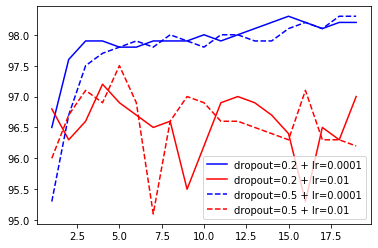

In [56]:
import matplotlib.pyplot as plt
plt.plot(range(1,20),matrix_1_1,'b',label='dropout=0.2 + lr=0.0001')
plt.plot(range(1,20),matrix_1_2,'r',label='dropout=0.2 + lr=0.01')

plt.plot(range(1,20),matrix_2_1,'--b',label='dropout=0.5 + lr=0.0001')
plt.plot(range(1,20),matrix_2_2,'--r',label='dropout=0.5 + lr=0.01')

plt.legend()